In [1]:
%matplotlib qt

import mne
import matplotlib.pyplot as plt
import numpy as np
import enum
import os

In [2]:
TUH_EEG_SEIZURE_CORPUS = "/Users/jannis/Git/tuh-eeg-seizure-detection/data/raw"
OUTPUT = "/dhc/cold/groups/metrics/data/processed"

In [3]:
class Recording:
    path: str
    annotations: mne.Annotations
    
    # seizures are tuples of onset and duration
    seizures: list[(float, float)]
    
    # non-seizures are tuples of onset and duration
    non_seizures: list[(float, float)]
    
    
    def __init__(self, path: str):
        self.path = path
        self.annotations = self._parse_annotation_file()
        
        self.seizures = [(self.annotations.onset[i], self.annotations.duration[i]) for i, x in enumerate(self.annotations.description) if x == "seiz"]
        self.non_seizures = [(self.annotations.onset[i], self.annotations.duration[i]) for i, x in enumerate(self.annotations.description) if x == "bckg"]
        
    
    def _parse_annotation_file(self):
        annotation_file = self.path.replace(".edf", ".csv_bi")
        raw_annotations: list[str] = []

        with open(annotation_file, "r") as f:
            for line in f:
                raw_annotations.append(line)

        raw_annotations = raw_annotations[6:]

        onset: list[float] = []
        duration: list[float] = []
        description: list[str] = []
        
        for line in raw_annotations:
            parts = line.split(",")
            start = parts[1]
            end = parts[2]
            label = parts[3]
            
            onset.append(float(start))
            duration.append(float(end) - float(start))
            description.append(label)

        return mne.Annotations(onset, duration, description)
    
    
    def plot(self):
        raw = mne.io.read_raw_edf(self.path)
        raw.set_annotations(self.annotations)
        raw.plot()
 
class Session:
    session_id: str
    recordings: list[Recording]
    configuration: str
    
    def __init__(self, session_id: str, recordings: list[Recording], configuration: str):
        self.session_id = session_id
        self.recordings = recordings
        self.configuration = configuration
        

class Patient:
    patient_id: str
    sessions: list[Session]
    
    def __init__(self, patient_id, sessions: list[Session]):
        self.patient_id = patient_id
        self.sessions = sessions

In [11]:
# Load all patients
patients: list[Patient] = []

# iterate over all data sets in the TUH EEG Seizure Corpus edf folder
for data_set in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf"):
    if not data_set.isdir():
        continue
        
    # iterate over all patients in the data set
    for patient in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}"):
        sessions = []
        
        # iterate over all sessions in the patient folder
        for session in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}"):
            # configuration is the first and only folder in the session folder
            configuration = os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}/{session}")[0]
            
            recordings = []
            
            # iterate over all files in the configuration folder
            for file in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}/{session}/{configuration}"):
                if not file.endswith(".edf"):
                    continue
                    
                recording = Recording(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}/{session}/{configuration}/{file}")
                recordings.append(recording)
            
            sessions.append(Session(session, recordings, configuration))
        
        patients.append(Patient(patient, sessions))
        
patients

AttributeError: 'str' object has no attribute 'isdir'

In [5]:
# check if there are duplicate patients across data sets
patient_ids = [patient.patient_id for patient in patients]
duplicates = set([x for x in patient_ids if patient_ids.count(x) > 1])
duplicates

set()

In [8]:
# check if there are patients without seizures
patients_without_seizures: list[Patient] = [] 
patients_with_and_without_seizures: list[Patient] = []
patients_with_seizures: list[Patient] = []

for patient in patients:
    has_non_seizure = False
    has_seizures = False
    
    for session in patient.sessions:
        for recording in session.recordings:
            if len(recording.seizures) > 0:
                has_seizures = True
                
            if len(recording.non_seizures) > 0:
                has_non_seizure = True
            
    if has_seizures and has_non_seizure:
        patients_with_and_without_seizures.append(patient)
    elif has_seizures:
        patients_with_seizures.append(patient)
    else:
        patients_without_seizures.append(patient)
       
len(patients_without_seizures), len(patients_with_seizures), len(patients_with_and_without_seizures)

(0, 0, 0)

In [51]:
# calc total seizure and non-seizure duration
seizure_duration = 0
non_seizure_duration = 0
selected_configurations = ["01_tcp_ar", "02_tcp_le", "03_tcp_ar_a", "04_tcp_le_a"]

for patient in patients_with_seizures:
    for session in patient.sessions:
        if session.configuration not in selected_configurations:
            continue
            
        for recording in session.recordings:
            seizure_duration += sum([x[1] for x in recording.seizures])
            non_seizure_duration += sum([x[1] for x in recording.non_seizures])
            
            
seizure_duration / 3600, non_seizure_duration / 3600

(76.17875672222233, 307.05807302777777)

In [55]:
# calc number of possible windows (non-overlapping) for seizure and non-seizure data
window_size = 120 # window size in seconds
selected_configurations = ["01_tcp_ar"]

seizure_windows = 0
non_seizure_windows = 0

for patient in patients_with_seizures:
    for session in patient.sessions:
        # skip session if configuration is not in selected configurations
        if session.configuration not in selected_configurations:
            continue
        
        for recording in session.recordings:
            seizures = recording.seizures
            non_seizures = recording.non_seizures
            
            for seizure in seizures:
                # if seizure duration is smaller than window size, skip
                if seizure[1] < window_size:
                    continue
                    
                # number of windows is floor of seizure duration divided by window size
                seizure_windows += int(seizure[1] // window_size)
            
            for non_seizure in non_seizures:
                # if non-seizure duration is smaller than window size, skip
                if non_seizure[1] < window_size:
                    continue
                    
                # number of windows is floor of non-seizure duration divided by window size
                non_seizure_windows += int(non_seizure[1] // window_size)
                
print(seizure_windows, non_seizure_windows)
(seizure_windows * window_size)/3600, (non_seizure_windows * window_size)/3600 # total duration of seizure and non-seizure windows in hours

578 6668


(19.266666666666666, 222.26666666666668)

Average number of windows: 317.2413793103448
Minimum number of windows: 0
Maximum number of windows: 3628
Standard deviation of number of windows: 587.2081024041919
Median number of windows: 59.5


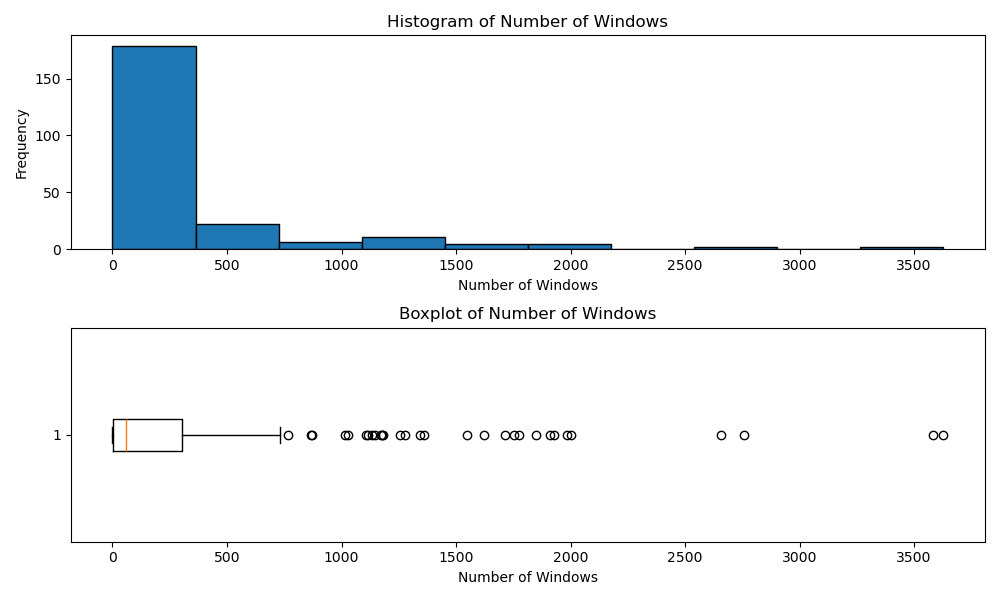

In [66]:
def get_windows(window_size: int, patient: Patient):
    non_seizure_windows = 0
    seizure_windows = 0
    
    for session in patient.sessions:
        for recording in session.recordings:
            seizures = recording.seizures
            non_seizures = recording.non_seizures
            
            for seizure in seizures:
                # if seizure duration is smaller than window size, skip
                if seizure[1] < window_size:
                    continue
                    
                # number of windows is floor of seizure duration divided by window size
                seizure_windows += int(seizure[1] // window_size)
            
            for non_seizure in non_seizures:
                # if non-seizure duration is smaller than window size, skip
                if non_seizure[1] < window_size:
                    continue
                    
                # number of windows is floor of non-seizure duration divided by window size
                non_seizure_windows += int(non_seizure[1] // window_size)
                
    return seizure_windows, non_seizure_windows

# Collect num_windows for each patient
num_windows_list = []

for patient in patients_with_and_without_seizures:
    seizure_windows, non_seizure_windows = get_windows(2, patient)
    num_windows = min(seizure_windows, non_seizure_windows)
    num_windows_list.append(num_windows)

# Calculate statistics
avg_num_windows = np.mean(num_windows_list)
min_num_windows = np.min(num_windows_list)
max_num_windows = np.max(num_windows_list)
std_num_windows = np.std(num_windows_list)
median_num_windows = np.median(num_windows_list)

# Print statistics
print(f"Average number of windows: {avg_num_windows}")
print(f"Minimum number of windows: {min_num_windows}")
print(f"Maximum number of windows: {max_num_windows}")
print(f"Standard deviation of number of windows: {std_num_windows}")
print(f"Median number of windows: {median_num_windows}")

# Plotting the statistics
plt.figure(figsize=(10, 6))

# Histogram of num_windows
plt.subplot(2, 1, 1)
plt.hist(num_windows_list, bins=10, edgecolor='black')
plt.title('Histogram of Number of Windows')
plt.xlabel('Number of Windows')
plt.ylabel('Frequency')

# Boxplot of num_windows
plt.subplot(2, 1, 2)
plt.boxplot(num_windows_list, vert=False)
plt.title('Boxplot of Number of Windows')
plt.xlabel('Number of Windows')

plt.tight_layout()
plt.show()

[]